# CPR

My regressions are failing. Maybe this is because BBG doesn't have CPR data for fully paid off pools. So I'd better try again.

Popova <a href=http://projecteuclid.org/download/pdf_1/euclid.ba/1340370553>states</a> that the scheduled monthly payment is defined as follows: 
$$ MonthlyPayment = \frac{V \cdot \tfrac{r}{12} \cdot (1 + \tfrac{r}{12})^t}{(1 + \tfrac{r}{12})^t - 1} $$
$$ InterestPayment = V \cdot \frac{r}{12} $$
$$ ScheduledPrincipalPayment = MP - IP$$
Where $V$ is the face value of the loan, $r$ is the interest rate, and $t$ is the number of months since inception. She only looked at 8% loans.

Can I match up against Bloomberg CPR?

In [1]:
import os
os.chdir("/home/charles/src/LondonMirror/Prepayments/")
import prepayments as pp
import pandas as pd
import numpy as np
import datetime

In [2]:
import ggplot as gg

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
gnm_pool = pp.gnm_data.GNM_Pool()

In [5]:
samples = gnm_pool.get_samples(1000)

In [6]:
samples[0]

(2840929, '458371', datetime.datetime(2013, 1, 1, 0, 0))

In [7]:
samples[0] = (1698292, '687716', datetime.datetime(2012, 8, 1, 0, 0))

In [8]:
bbg = pp.Bloomberg()

In [9]:
cusip = gnm_pool.pools_table[samples[100][0]]["cusip"]
cusip

'36181NND2'

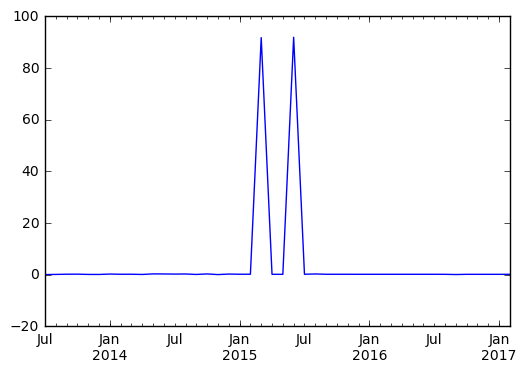

In [10]:
cpr_bbg = bbg.get_cpr(cusip)
cpr_bbg.plot()

In [11]:
p_data = gnm_pool.df_for_pool_number(samples[100][1])
p_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 2013-07-01 to 2016-12-01
Data columns (total 93 columns):
aols                                          42 non-null int64
as_of_date                                    42 non-null datetime64[ns]
cusip                                         42 non-null object
few_units_number_of_loans                     42 non-null int32
few_units_pct_of_upb                          42 non-null int32
few_units_upb                                 42 non-null int64
first_quartile_aols_q1                        42 non-null int64
first_quartile_cltv_q1                        42 non-null int16
first_quartile_ltv_q1                         42 non-null int16
first_quartile_wac_q1                         42 non-null int32
first_quartile_wagm_q1                        42 non-null int32
first_quartile_wala_q1                        42 non-null int16
first_quartile_waolt_q1                       42 non-null int16
first_quartile_warm_q1                     

In [12]:
p_data.ix[:,['security_interest_rate','wac']]

,security_interest_rate,wac
2013-07-01,3500,4000
2013-08-01,3500,4000
2013-09-01,3500,4000
2013-10-01,3500,4000
2013-11-01,3500,4000
2013-12-01,3500,4000
2014-01-01,3500,4000
2014-02-01,3500,4000
2014-03-01,3500,4000
2014-04-01,3500,4000


In [13]:
def scheduled_payment(prior_balance, interest_rate, loan_age, n_payments=360):
    rate = interest_rate / 1200000.
    principal_payment = rate / ((1+rate) ** (n_payments - loan_age) - 1)
    return principal_payment * prior_balance

def scheduled_balance(prior_balance, interest_rate, loan_age, n_payments=360):
    rate = interest_rate / 1200000.
    principal_payment = rate / ((1+rate) ** (n_payments - loan_age) - 1)
    return prior_balance - principal_payment * prior_balance

In [14]:
sp = pd.Series({dt:scheduled_payment(v['pool_upb'], v['security_interest_rate'], v['wala']) 
               for dt,v in p_data.iterrows()})

In [15]:
scheduled_payment(p_data['pool_upb'][0],p_data['security_interest_rate'][1],p_data['wala'][1])

177558.1326337888

In [16]:
p_data['as_of_date'][1]

Timestamp('2013-08-01 00:00:00')

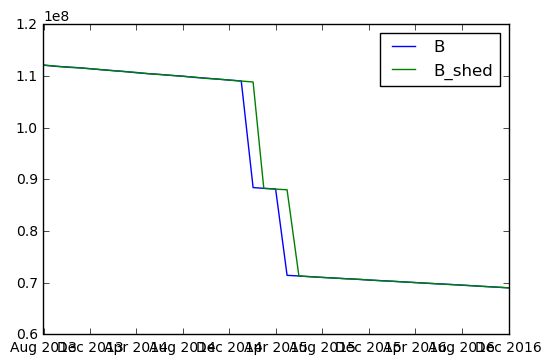

In [17]:
jim = pd.DataFrame({'B':p_data.ix[1:,'pool_upb'], 
                    'B_shed': [scheduled_balance(p_data['pool_upb'][i-1],
                                                  p_data['security_interest_rate'][i],
                                                 p_data['wala'][i]) 
                                for i in xrange(1,p_data.shape[0])]})
jim.plot()

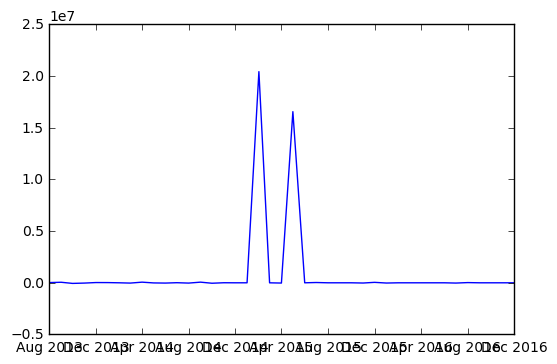

In [18]:
(jim.B_shed - jim.B).plot()

In [41]:
def cpr(p_data):
    sb = pd.Series({p_data['as_of_date'][i]:scheduled_balance(p_data['pool_upb'][i-1],
                                         p_data['security_interest_rate'][i],
                                         p_data['wala'][i]) 
               for i in xrange(1,p_data.shape[0])})
    smm = sb.sub(p_data.ix[1:,'pool_upb']).div(sb)
    cpr = 1 - (1-smm).pow(12)
    cpr.index = pd.DatetimeIndex(cpr.index)
    return cpr.shift(1)

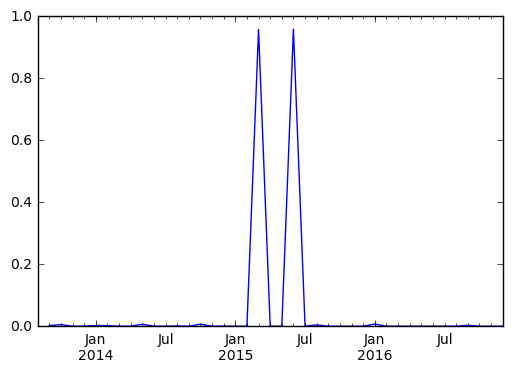

In [20]:
cpr(p_data).plot()

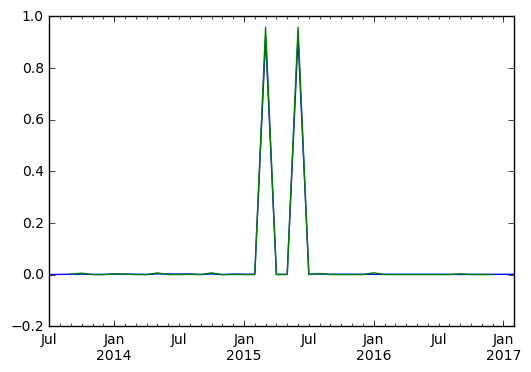

In [21]:
cpr_bbg.div(100).plot()
cpr(p_data).plot()

Let's look at some other pools.

In [58]:
def compare_cprs(index, data_cpr, gnm_pool):
    cusip = gnm_pool.pools_table[samples[index][0]]["cusip"]
    cpr_bbg = data_cpr.get_cpr_for_cusip(cusip)
    if cpr_bbg is not None:
        cpr_bbg = cpr_bbg.div(100)
    else:
        cpr_bbg = {}
    p_data = gnm_pool.df_for_pool_number(samples[index][1])
    alt_cpr = gnm_pool.cpr_for_pool_number(samples[index][1])
    return pd.DataFrame({'bbg':cpr_bbg, 
                         'me':cpr(p_data.ix[datetime.date(2012,9,1):,:]),
                        'pkg':alt_cpr.shift(1)})

In [23]:
data_cpr = pp.CPR_Data()

In [24]:
cusip = gnm_pool.pools_table[samples[60][0]]["cusip"]
cpr_bbg = data_cpr.get_cpr_for_cusip(cusip)

/usr/lib/python2.7/dist-packages/tables/group.py:501: PerformanceWarning: group ``/cpr`` is exceeding the recommended maximum number of children (16384); be ready to see PyTables asking for *lots* of memory and possibly slow I/O.
  PerformanceWarning)


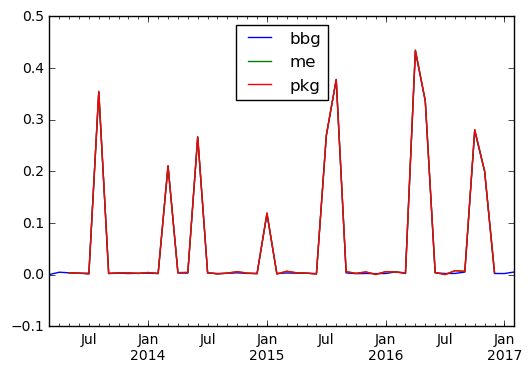

In [60]:
compare_cprs(900, data_cpr, gnm_pool).plot()

In [44]:
cprs = pd.Panel({i:compare_cprs(i, data_cpr, gnm_pool) for i in xrange(len(samples)-500)})

ERROR:root:No CPR data for 36216CKD8
ERROR:root:No CPR data for 36205TQS5
ERROR:root:No CPR data for 36208R3S1
ERROR:root:No CPR data for 36217MRG1
ERROR:root:No CPR data for 36213EQ41
ERROR:root:No CPR data for 36209G5H6
ERROR:root:No CPR data for 36202WWJ4
ERROR:root:No CPR data for 36205EA71
ERROR:root:No CPR data for 362150X33
ERROR:root:No CPR data for 36203XRS7
ERROR:root:No CPR data for 36218YRT6
ERROR:root:No CPR data for 36292NP95
ERROR:root:No CPR data for 362146RR5
ERROR:root:No CPR data for 36212JG59
ERROR:root:No CPR data for 36200DGA5
ERROR:root:No CPR data for 36216CMJ3
ERROR:root:No CPR data for 36216ACJ8
ERROR:root:No CPR data for 36223M4C7
ERROR:root:No CPR data for 36230QME5
ERROR:root:No CPR data for 36220EW86
ERROR:root:No CPR data for 36294WYL6
ERROR:root:No CPR data for 36207KMY3
ERROR:root:No CPR data for 36206VMH7
ERROR:root:No CPR data for 36209BCQ9
ERROR:root:No CPR data for 36224QV86
ERROR:root:No CPR data for 362165ZG0
ERROR:root:No CPR data for 36296XNR1
E

In [45]:
cprs

<class 'pandas.core.panel.Panel'>
Dimensions: 500 (items) x 373 (major_axis) x 2 (minor_axis)
Items axis: 0 to 499
Major_axis axis: 1986-02-01 00:00:00 to 2017-02-01 00:00:00
Minor_axis axis: bbg to me

In [46]:
cprs.swapaxes('minor','items').to_frame().reset_index().head()

,major,minor,bbg,me
0,2012-11-01,0,0.0629,0.062732
1,2012-11-01,1,0.0089,0.011438
2,2012-11-01,2,0.0115,0.139167
3,2012-11-01,3,0.0000,0.000000
4,2012-11-01,4,0.0000,0.000000


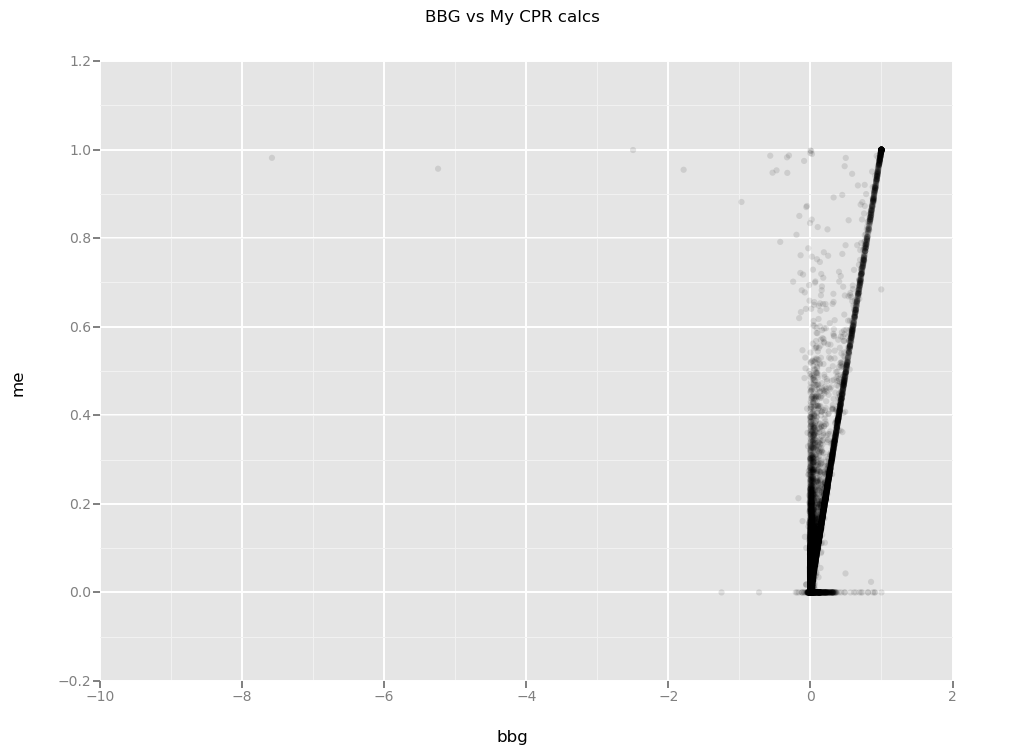

<ggplot: (8747305152617)>

In [47]:
gg.ggplot(cprs.swapaxes('minor','items').to_frame().reset_index(), 
         gg.aes(x='bbg',y='me')) + gg.geom_point(alpha=0.1) + \
        gg.ggtitle("BBG vs My CPR calcs")

In [50]:
cprs = cprs.swapaxes('minor','items').to_frame().reset_index()

ValueError: No axis named minor for object type <class 'pandas.core.frame.DataFrame'>

In [51]:
cprs.where(cprs.me < -0).dropna()

,major,minor,bbg,me


In [52]:
samples[11]

(1645593, '589653', datetime.datetime(2012, 8, 1, 0, 0))

In [38]:
df = gnm_pool.df_for_pool_number('589653')
df.tail()

,aols,as_of_date,cusip,few_units_number_of_loans,few_units_pct_of_upb,few_units_upb,first_quartile_aols_q1,first_quartile_cltv_q1,first_quartile_ltv_q1,first_quartile_wac_q1,...,third_quartile_waolt_q3,third_quartile_warm_q3,wac,wagm,wala,waolt,warm,weighted_average_original_cltv,weighted_average_original_loan_size,weighted_average_original_ltv
2013-12-01,99999999,2013-12-01,36201QBW2,0,0,0,99999999,999,999,99999,...,999,999,99999,99999,999,999,999,999,99999999,999
2014-01-01,99999999,2014-01-01,36201QBW2,0,0,0,99999999,999,999,99999,...,999,999,99999,99999,999,999,999,999,99999999,999
2014-02-01,99999999,2014-02-01,36201QBW2,0,0,0,99999999,999,999,99999,...,999,999,99999,99999,999,999,999,999,99999999,999
2014-03-01,99999999,2014-03-01,36201QBW2,0,0,0,99999999,999,999,99999,...,999,999,99999,99999,999,999,999,999,99999999,999
2014-04-01,99999999,2014-04-01,36201QBW2,0,0,0,99999999,999,999,99999,...,999,999,99999,99999,999,999,999,999,99999999,999


That's a mistake in the data, I think.

In [39]:
df.cusip[0]

'36201QBW2'

In [ ]:
gnm_pool.pools_table.read_where()

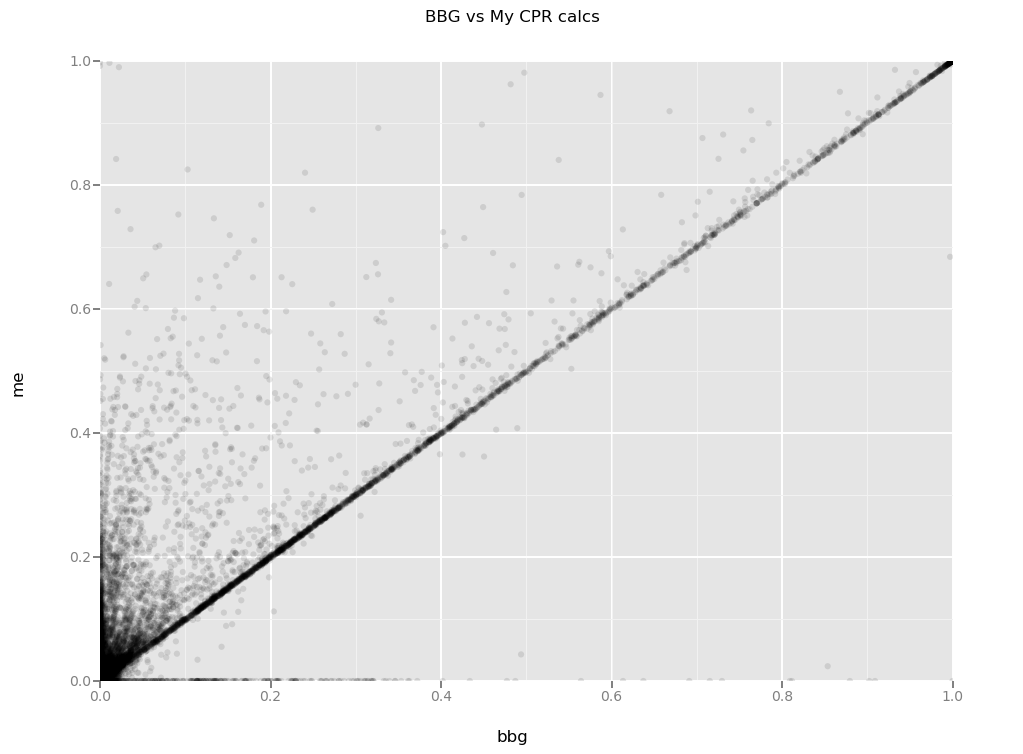

<ggplot: (8747304900577)>

In [53]:
gg.ggplot(cprs, gg.aes(x='bbg',y='me')) + gg.geom_point(alpha=0.1) + \
        gg.ggtitle("BBG vs My CPR calcs") + gg.xlim(0,1) + gg.ylim(0,1)

In [37]:
df = gnm_pool.df_for_pool_number('000456')

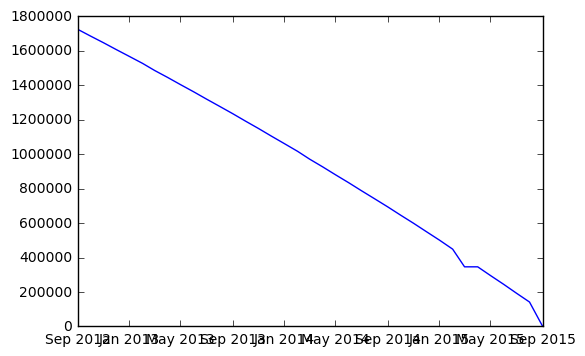

In [38]:
df.pool_upb.plot()

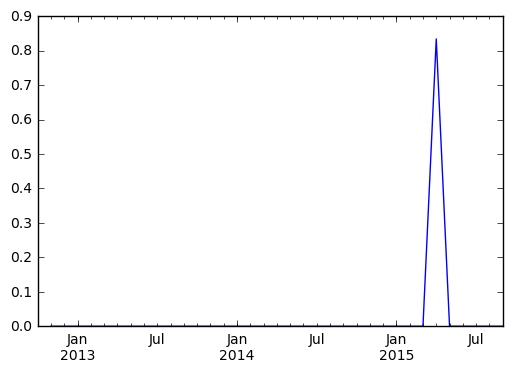

In [47]:
cpr(df).plot()

In [53]:
df.ix[-1,'wala'] = df.ix[-2, 'wala'] + 1
df.ix[-1,'security_interest_rate'] = df.ix[-2, 'security_interest_rate']

In [54]:
cpr(df).tail()

2015-05-01    0.0
2015-06-01    0.0
2015-07-01    0.0
2015-08-01    0.0
2015-09-01    0.0
dtype: float64

In [51]:
df.ix[-1,["as_of_date", "pool_upb"]]

as_of_date    2015-09-01 00:00:00
pool_upb                        0
Name: 2015-09-01, dtype: object

In [9]:
sp = pd.Series({df['as_of_date'][i]:gnm_pool.scheduled_payment(df['pool_upb'][i-1],
                                                         df['security_interest_rate'][i],
                                                         df['wala'][i])
             for i in xrange(1,df.shape[0])})

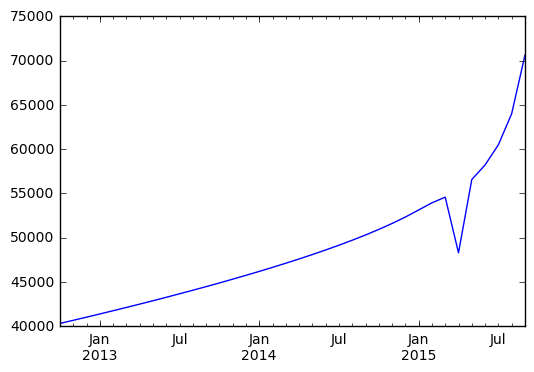

In [10]:
sp.plot()

In [14]:
jim = (0 - df['pool_upb']).diff().sub(1)

In [15]:
jim.tail(9)

2015-01-01     49496.0
2015-02-01     52208.0
2015-03-01    102698.0
2015-04-01        -1.0
2015-05-01     50471.0
2015-06-01     50892.0
2015-07-01     51316.0
2015-08-01     51744.0
2015-09-01    141747.0
Name: pool_upb, dtype: float64

In [ ]:
pd.Timestamp.f

In [18]:
jim.ix[jim < 0] = 0
jim.tail(9)

2015-01-01     49496.0
2015-02-01     52208.0
2015-03-01    102698.0
2015-04-01         0.0
2015-05-01     50471.0
2015-06-01     50892.0
2015-07-01     51316.0
2015-08-01     51744.0
2015-09-01    141747.0
Name: pool_upb, dtype: float64

In [26]:
df.ix[-1]['pool_upb']

0

In [40]:
df.ix[-1]['wala']

358

In [39]:
df.loc[df.index[-1], 'wala'] = df.ix[-2]['wala']+1

In [42]:
df['security_interest_rate']

2012-09-01    9500
2012-10-01    9500
2012-11-01    9500
2012-12-01    9500
2013-01-01    9500
2013-02-01    9500
2013-03-01    9500
2013-04-01    9500
2013-05-01    9500
2013-06-01    9500
2013-07-01    9500
2013-08-01    9500
2013-09-01    9500
2013-10-01    9500
2013-11-01    9500
2013-12-01    9500
2014-01-01    9500
2014-02-01    9500
2014-03-01    9500
2014-04-01    9500
2014-05-01    9500
2014-06-01    9500
2014-07-01    9500
2014-08-01    9500
2014-09-01    9500
2014-10-01    9500
2014-11-01    9500
2014-12-01    9500
2015-01-01    9500
2015-02-01    9500
2015-03-01    9500
2015-04-01    9500
2015-05-01    9500
2015-06-01    9500
2015-07-01    9500
2015-08-01    9500
2015-09-01    9500
Name: security_interest_rate, dtype: int32